In [34]:
%load_ext autoreload
%autoreload 2

In [51]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [52]:
TOTAL_TIME_STEPS = 300_000 #number of training timesteps
BUFFER_SIZE = 10_000
TIMEOUT_STEPS = 300 # Timeout Steps of each episode 
LEARNING_RATE = 0.000001
EXPLORATION_NOISE_STD = 0.05

REWARDS = Rewards(target_arrival=10, collision=-20, timeout=-10, idle=-0.01)

# EVAL_EPISODES = 30
EVAL_FREQ = 10_000
VIDEO_FREQ = 10 # record video every VIDEO_FREQ evaluation episodes

# create environment :
tile_size = 0.1
maze_size = mtmz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
circle_radius = 3
maze_map = make_circular_map(map_size, circle_radius / tile_size)
# maze_map = np.zeros(map_size)

start_loc = (5, 5)
targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')

maze_env = mtmz.MultiTargetMazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=start_loc,
                                   target_loc_list=targets,
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
maze_env = Monitor(maze_env, filename="logs/MultiTargets/results")

check_env(maze_env)

# create separete evaluation environment:
eval_maze_env =mtmz.MultiTargetMazeEnv(maze_size=maze_size,
                                       maze_map=maze_map,
                                       tile_size=tile_size,
                                       start_loc=start_loc,
                                       target_loc_list=targets,
                                       timeout_steps=TIMEOUT_STEPS,
                                       show_gui=False,
                                       rewards=REWARDS)
 
# create model:
exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

file_writer = tf.summary.create_file_writer(logdir + "/metrics")

torch.manual_seed(1800)
model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             action_noise=exploration_noise,
             device=device,
             train_freq=(1, "episode"),
             verbose=0,
             tensorboard_log="./logs/FineTuneMultiple/tb")

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir="logs/MultiTargets",
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

argv[0]=
argv[0]=


In [53]:
# clear old videos: 
clear_files('logs/MultiTargets/*.gif')
clear_files('logs/MultiTargets/*.avi')

In [54]:
start = time.time()

#clean all movies from the previous run
clear_files('logs/MultiTargets/*_steps.avi')

torch.manual_seed(1800)

model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback,
            tb_log_name="1800_seed_Long")
 
print("time", time.time() - start)

10000 Steps evaluation, avg reward:-11.564999999999987, avg episode length: 290.8333333333333
--Saving new best model--
20000 Steps evaluation, avg reward:-9.433333333333318, avg episode length: 277.6666666666667
--Saving new best model--
30000 Steps evaluation, avg reward:-12.98999999999999, avg episode length: 300.0
40000 Steps evaluation, avg reward:-10.237666666666652, avg episode length: 291.43333333333334
50000 Steps evaluation, avg reward:-11.589666666666654, avg episode length: 293.3
60000 Steps evaluation, avg reward:-12.27233333333332, avg episode length: 294.9
70000 Steps evaluation, avg reward:-8.74133333333332, avg episode length: 275.1333333333333
--Saving new best model--
80000 Steps evaluation, avg reward:-8.810333333333316, avg episode length: 282.03333333333336
90000 Steps evaluation, avg reward:-10.843333333333321, avg episode length: 285.3333333333333
100000 Steps evaluation, avg reward:-9.11966666666665, avg episode length: 279.6333333333333
creating video
110000 S

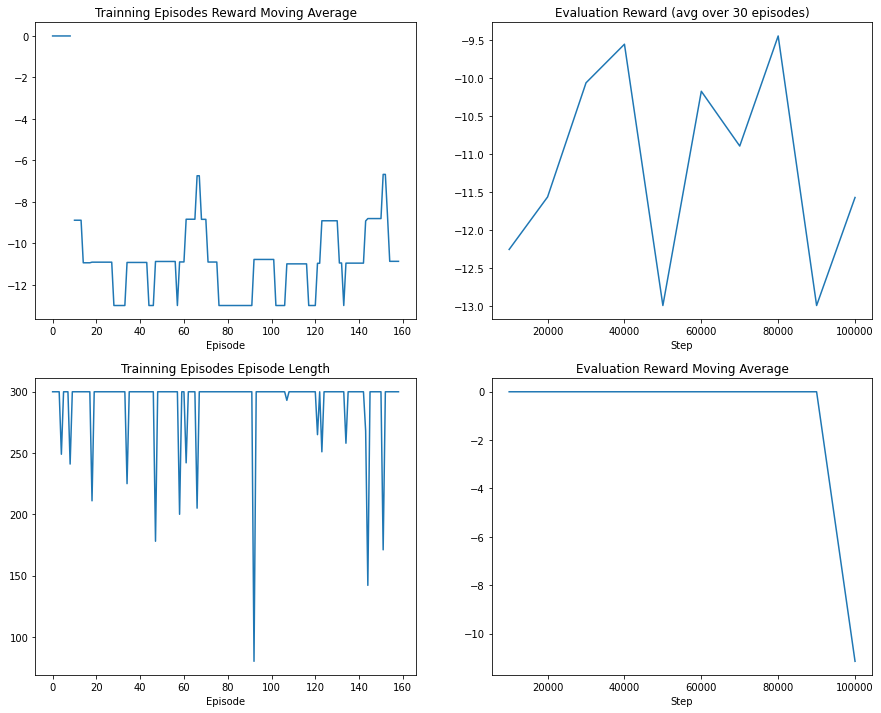

In [46]:
Evaluation.plot_train_eval_results("logs/MultiTargets", 30)

In [ ]:
N_TARGETS_TO_VISUALIZE = 30

rewards = []
reach_target_count = 0

for tgt in range(N_TARGETS_TO_VISUALIZE):
    episode_reward = 0
    done = False
    video_path = os.path.join(new_results_dir, "OldFinal", "final" + str(tgt) + ".avi")
    print(video_path)
    obs = env.reset(create_video=True, video_path=video_path, target_index=tgt)
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
    
    
    rewards.append("reward: " + str(episode_reward)+ "\n hit target: " + str(info["hit_target"]))
    if episode_reward > 0:
        reach_target_count += 1
    
_ = env.reset()

Evaluation.create_gifs_from_avi(os.path.join(new_results_dir, "OldFinal"))

print("reached target:", reach_target_count)

In [40]:
from IPython.display import Image
import ipyplot
import glob

# create gifs and plot them:
Evaluation.create_gifs_from_avi("logs/MultiTargets")

gifs = glob.glob(os.path.join(new_results_dir, "OldFinal","*.gif"))
gifs.sort()
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
labels.sort()

# ipyplot.plot_images(gifs, labels, rewards, img_width=200)
ipyplot.plot_images(gifs, labels, rewards, img_width=200)

IndexError: list index out of range

In [15]:
# load best model
best_model = DDPG.load("./logs/MultiTargets/best_model",env=maze_env)

# evaluate for last final episode (random target)
episode_reward = Evaluation.record_model(best_model, eval_maze_env, "logs/MultiTargets/final/final.avi")
print("Final Evaluation Reward:", episode_reward)

Evaluation.create_gifs_from_avi("logs/MultiTargets/final")

gifs = glob.glob("logs/MultiTargets/final/final.gif")
print(gifs)
ipyplot.plot_images(gifs, img_width=250)

Final Evaluation Reward: 7.92
['logs/MultiTargets/final/final.gif']


In [ ]:
best_model